In [36]:
%load_ext lab_black
import matplotlib
from matplotlib import style

style.use("seaborn")
import matplotlib.pyplot as plt
import datetime as dt
import time
import pandas as pd
import numpy as np
from scipy import stats
from datetime import *

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [37]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [38]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [40]:
cols = inspector.get_columns("measurement")
for column in cols:
    print(column["name"], column["type"], column["primary_key"])

id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0


In [41]:
cols = inspector.get_columns("station")
for column in cols:
    print(column["name"], column["type"], column["primary_key"])

id INTEGER 1
station TEXT 0
name TEXT 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [42]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measurement = Base.classes.measurement

In [43]:
session = Session(engine)

In [44]:
Base.classes.keys()

['measurement', 'station']

In [45]:
date_max = session.query(func.max(Measurement.date)).first()[0]
date_max = dt.datetime.strptime(date_max, "%Y-%m-%d").date()
year_before = date_max - timedelta(365)

In [46]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


In [47]:
latest_date = dt.date(2017, 8, 23)

In [48]:
query_date = latest_date - dt.timedelta(days=365)
print(query_date)
results = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= query_date)
    .all()
)
df = pd.DataFrame(results, columns=["date", "precipitation"])
# df = df.sort_values("date", ascending=True)
df = df.set_index("date")
df.head()

2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [49]:
date_prcp_query = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= "2016-08-23", Measurement.date <= "2017-08-23")
    .order_by(Measurement.date)
    .statement
)

In [50]:
date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(5)

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


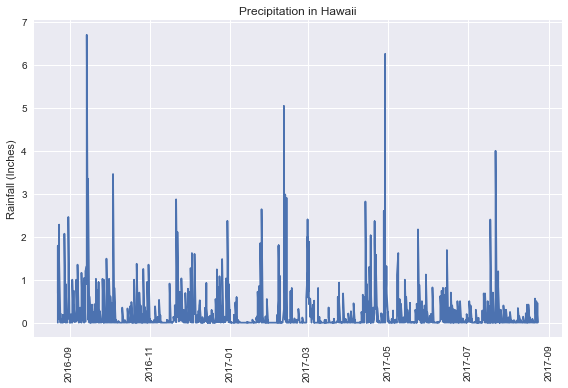

In [51]:
date_prcp_df["date"] = pd.to_datetime(date_prcp_df["date"])
plt.plot(date_prcp_df["date"], date_prcp_df["prcp"])
plt.title("Precipitation in Hawaii")
plt.xlabel("")
plt.ylabel("Rainfall (Inches)")
plt.xticks(rotation="90")
plt.tight_layout()
plt.show()

In [52]:
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [53]:
cols = inspector.get_columns("station")
for column in cols:
    print(column["name"], column["type"], column["primary_key"])

id INTEGER 1
station TEXT 0
name TEXT 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [54]:
cols = inspector.get_columns("measurement")
for column in cols:
    print(column["name"], column["type"], column["primary_key"])

id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0


In [55]:
session.query(Station.name).count()

9

In [56]:
session.query(Measurement.station, func.count(Measurement.station)).group_by(
    Measurement.station
).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
session.query(
    Station.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.count(Measurement.station),
).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(
    func.count(Measurement.station).desc()
).first()

('USC00519281',
 'WAIHEE 837.5, HI US',
 21.45167,
 -157.84888999999998,
 32.9,
 2772)

In [58]:
tob_results = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == "USC00519281")
    .all()
)
print(tob_results)

[(54.0, 85.0, 71.66378066378067)]


In [59]:
df_tob = pd.DataFrame(tob_results, columns=["min", "max", "avg"])
df_tob.describe()

,min,max,avg
count,1.0,1.0,1.000000
mean,54.0,85.0,71.663781
std,NaN,NaN,NaN
min,54.0,85.0,71.663781
25%,54.0,85.0,71.663781
50%,54.0,85.0,71.663781
75%,54.0,85.0,71.663781
max,54.0,85.0,71.663781


In [60]:
query_date = latest_date - dt.timedelta(days=365)
print(query_date)
results = (
    session.query(Measurement.tobs)
    .filter(Measurement.date >= query_date)
    .filter(Measurement.station == "USC00519281")
    .all()
)
df = pd.DataFrame(results, columns=["precipitation"])
# df = df.sort_values("date", ascending=True)
# df = df.set_index("precipitation")
df.head()

2016-08-23


,precipitation
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


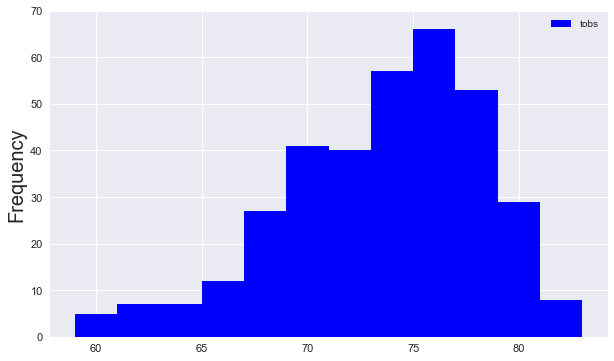

In [61]:
bins = []
fig, ax = plt.subplots(figsize=(10, 6))
df.hist(bins=12, ax=ax, color="blue", xlabelsize=11, ylabelsize=11, label="tobs")
ax.set_title("")
ax.legend()
plt.rc("legend", fontsize=25)
ax.set_ylabel("Frequency", fontsize=20)
ax.set_ylim(top=70)
fig.savefig("Images/tobs.png")

In [62]:
def calc_temps(start_date, end_date):
    sd = dt.datetime.strptime(start_date, "%Y-%m-%d")
    ed = dt.datetime.strptime(end_date, "%Y-%m-%d")
    result = (
        session.query(
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.min(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )
    return result

In [63]:
def calc_temps(start_date, end_date):
    sd = dt.datetime.strptime(start_date, "%Y-%m-%d")
    ed = dt.datetime.strptime(end_date, "%Y-%m-%d")
    result = (
        session.query(
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.min(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )
    return result

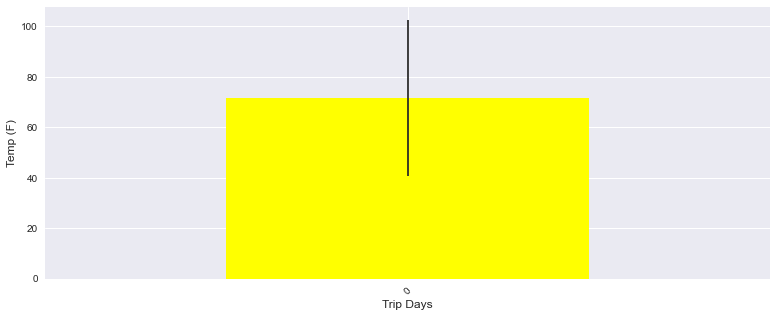

In [64]:
yerr = df_tob["max"] - df_tob["min"]
fig, ax = plt.subplots(figsize=(13, 5))
df_tob["avg"].plot(kind="bar", color="yellow", yerr=yerr, ax=ax)
ax.set_ylabel("Temp (F)", fontsize=12)
ax.set_xlabel("Trip Days", fontsize=12)

for tick in ax.get_yticklabels():
    tick_setfontsize = 10
for value in ax.get_xticklabels():
    #     value.
    value.set_fontsize = 20
    value.set_rotation(45)
fig.savefig("Images/temp.png")

In [65]:
def calc_rainfall(start_date, end_date):
    sd = dt.datetime.strptime(start_date, "%Y-%m-%d")
    ed = dt.datetime.strptime(end_date, "%Y-%m-%d")
    result = (
        session.query(Measurement.station, func.sum(Measurement.prcp))
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .group_by(Measurement.station)
        .all()
    )
    return result

In [66]:
trip_start = "2017-01-01"
trip_end = "2017-01-10"  # dates one year ago
rainfall_trip = calc_rainfall(trip_start, trip_end)
df_triprainfall = pd.DataFrame(rainfall_trip, columns=["Station", "Total Rainfall"])
df_triprainfall

,Station,Total Rainfall
0,USC00513117,0.35
1,USC00514830,0.63
2,USC00516128,0.63
3,USC00517948,NaN
4,USC00519281,0.20
5,USC00519397,0.00
6,USC00519523,0.61


In [67]:
def daily_normals(date):
    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    daily_normal = (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )
    return daily_normal

In [68]:
trip_st = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_duration = 9  # days
trip_min = []
trip_avg = []
trip_max = []
trip_date = []
for day in range(trip_duration):
    date = trip_st + dt.timedelta(days=day)
    date_str = dt.datetime.strftime(date, "%m-%d")
    (normals,) = daily_normals(date_str)
    trip_min.append(normals[0])
    trip_avg.append(normals[1])
    trip_max.append(normals[2])
    trip_date.append(date_str)
trip_normals = {
    "Trip_Date": trip_date,
    "Min_Temp": trip_min,
    "Average_Temp": trip_avg,
    "Max_Temp": trip_max,
}
df_trip_nortemps = pd.DataFrame(
    trip_normals, columns=["Trip_Date", "Min_Temp", "Average_Temp", "Max_Temp"]
)
df_trip_nortemps = df_trip_nortemps.set_index("Trip_Date")
df_trip_nortemps

,Min_Temp,Average_Temp,Max_Temp
Trip_Date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


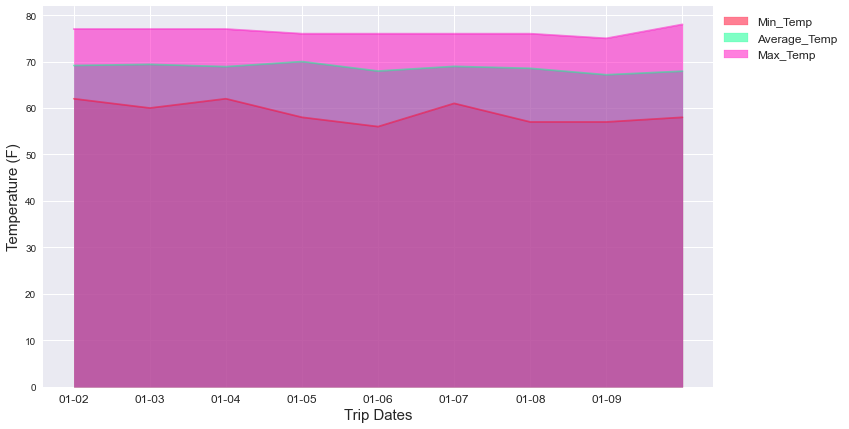

In [69]:
fig, ax = plt.subplots(figsize=(12, 7))
df_trip_nortemps.plot(kind="area", ax=ax, stacked=False, alpha=0.5, cmap="gist_rainbow")
ax.legend(bbox_to_anchor=(1, 1), loc="best", fontsize="large")
ax.set_xticklabels(labels=df_trip_nortemps.index, fontsize=12)
ax.set_ylabel("Temperature (F)", fontsize=15)
ax.set_xlabel("Trip Dates", fontsize=15)
fig.savefig("Images/temp2.png")

In [70]:
year_range = latest_date - dt.timedelta(days=365)

# Querying date and pcpt from db
results_prcp = (
    session.query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date > year_range)
    .group_by(Measurement.date)
    .all()
)

# Creating dictionary from query results and append to a list
results = []

for result in results_prcp:
    x = np.ravel(result)
    prcp_dict = {}
    prcp_dict["Date"] = x[0]
    prcp_dict["Prcp"] = x[1]
results.append(prcp_dict)
results
# prcp_dict

[{'Date': '2017-08-23', 'Prcp': '0.1325'}]